In [ ]:
# Импорты всего
import os, gc, h5py, numpy as np, pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# наше добро
from methods.io_and_processing import generate_combinations, calculate_events_vs_pore_pressure, resample_events, detect_peaks_findpeaks, align_peaks
from methods.events_plotting import plot_events_vs_pressure, plot_peak_histograms, plot_r_histograms, plot_sigma2_histograms
from methods.events_plotting import  plot_cpp_err_single_kappa, plot_r_err_single_kappa, plot_sigma2_err_single_kappa

### Моделирование для сетки комбинаций параметров

In [2]:
# На первом этапе генерируем как можно более гладкие кривые событий от времени
# Задаём варьируемые параметры моделирования в виде [списков значений], потом из них будут созданы все возможные комбинации параметров
all_params = {
        # для среды
        'ro_s' : 2300, # плотность породы, кг/м3
        'ro_f' : 1000, # плотность флюида, кг/м3
        'depth' : [1000, 2000, 3000, ], # глубина, м

        # для трещин
        'mu' : [0.5, 0.6, 0.7, ], # коэффициент трения
        'cohesion' : 0.01, # коэффициент сцепления МПа
        'kappa' : [0.01, 0.1, 1, 5, 10, 25, 50, ], # праметр кучности
        'N_frac': 1000000, # суммарное большое количество трещин, чтоьбы получить гладкие кривые

        # для НДС
        'r' : [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ], # коэффициент Лоде-Надаи
    }

# имя файла для сохранения результатов
h5_path = f"events_vs_pressure_smooth_lines__{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5"

# итерируемся по всем комбинациям параметров и сохраняем все в листы
meta, pressures, events = [], [], []
for params in tqdm(generate_combinations(all_params)):
    ev, pr, (cpp_31, cpp_21, cpp_32), ps = calculate_events_vs_pore_pressure(params, press_steps=100) # вся магия тут
    pp = params.copy()
    pp.update({'cpp_31': cpp_31, 'cpp_21': cpp_21, 'cpp_32': cpp_32}) #  запоминаем значения критического давления для кругов трех кругов Мора
    s3, s2, s1 = np.sort(ps)
    pp.update({'s1': s1, 's2': s2, 's3': s3})  # запоминаем значения принципиальных компонент
    meta.append(pp)
    pressures.append(pr)
    events.append(ev)

# сохранение в файл
df = pd.DataFrame(meta)
with h5py.File(h5_path, "w") as f:
    f.create_dataset("meta",    data=df.to_records(index=False))
    f.create_dataset("pressure",data=np.stack(pressures, axis=0))
    f.create_dataset("events",  data=np.stack(events,    axis=0))

# приборка
# gc.collect() 

  0%|          | 0/693 [00:00<?, ?it/s]

### как потом читать данные 

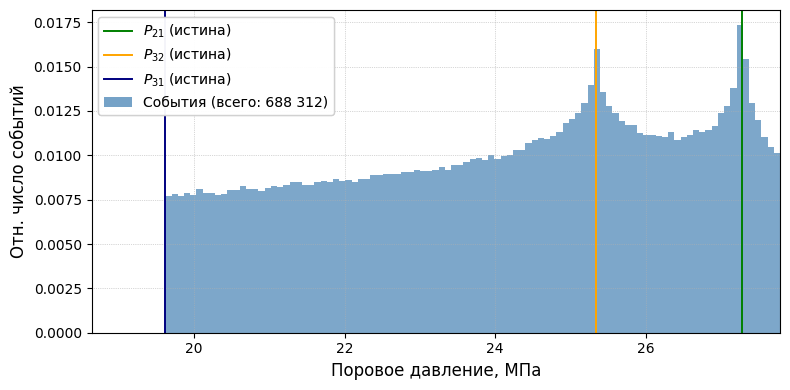

In [3]:
# задаём определенный набор параметров для среза данных 
spec_params = {
        # для среды
        'depth' : 2000, # глубина, м

        # для трещин
        'mu' : 0.6, # коэффициент трения
        # 'kappa' : 5, # праметр кучности
        # для НДС
        'r' : 0.3, # коэффициент Лоде-Надаи
    }

# Читаем из файла c "гладкими" кривыми таблицу параметров («meta») 
h5_path = 'events_vs_pressure_smooth_lines__2025-06-23_13-37-12.h5'

with h5py.File(h5_path, "r") as f:
    df_meta = pd.DataFrame(f["meta"][:])   

# Строим маску по словарю spec_params
mask = np.ones(len(df_meta), dtype=bool)
for key, value in spec_params.items():
    if key in df_meta.columns:
        mask &= (df_meta[key] == value)
        
# Срез датафрейма с параметрами
df_sel = df_meta[mask] 

# Срезы давлений и событий
with h5py.File(h5_path, "r") as f:
    press = f["pressure"][mask]
    events = f["events"][mask]

# press и events - двумерные массивы, та как spec_params могут удовлетворять несколько вариантов кривых.
# Например, если не указать в spec_params 'kappa', то в срезе будут набор кривых для всех имеющихся в файле kappa
idx = 1 # индекс для какого то там каппа
cpps=tuple(df_sel[["cpp_31", "cpp_21", "cpp_32"]].to_numpy()[idx]) # критические давления
plot_events_vs_pressure(press[idx], events[idx], cpps=cpps) 

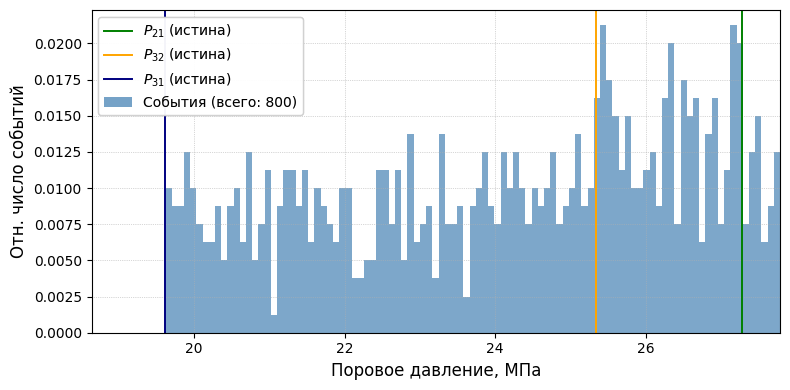

In [6]:
# семплиуем кривую с другим общим количеством событий, 
# обытия сэмплируются из многомерного биномиального распределения 
# с вероятностями - оносительными плотностями событий в исходных кривых. 
# Таким образом мы имитируем ситуацию, когда вместо «миллиона» событий наблюдается лишь N,
# но статистический «рисунок» по давлению остаётся тем же в среднем.
resampled_events = resample_events(events, N=800) 
plot_events_vs_pressure(press[idx], resampled_events[idx], cpps=cpps) 

### Ищем пики

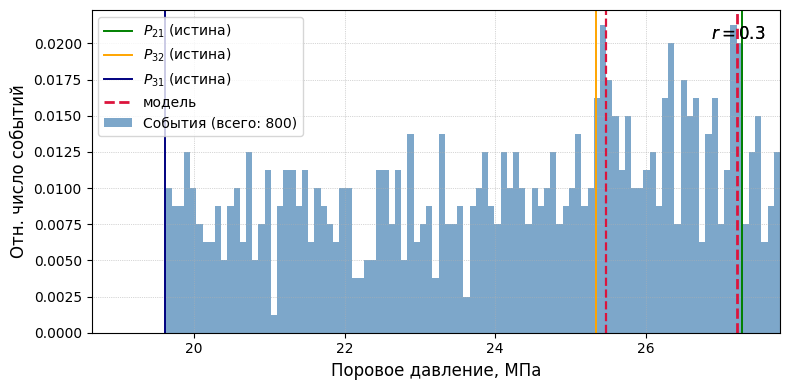

In [7]:
_, cpps_preds = detect_peaks_findpeaks(resampled_events, press, n_peaks=2)

plot_events_vs_pressure(press[idx], resampled_events[idx], cpps=cpps, cpps_preds=cpps_preds[idx], params=spec_params) 

### Если нужна только одна какая то модель для отрисовки картинок, 
то можно передать адрес папки, тогда в нее все будет сохранено

In [2]:
params = {
        # для среды
        'ro_s' : 2300, # плотность породы, кг/м3
        'ro_f' : 1000, # плотность флюида, кг/м3
        'depth' : 2000, # глубина, м

        # для трещин
        'mu' : 0.6, # коэффициент трения
        'cohesion' : 0.01, # коэффициент сцепления МПа
        'kappa' : 15, # праметра кучности
        'N_frac': 1e3, # суммарное количество трещин

        # для НДС
        'r' : 0.4, # коэффициент Лоде-Надаи
    }

events, pressure, cpps = calculate_events_vs_pore_pressure(params, press_steps=100, save_path='del_me_fold')

### Задача о выделении пиков, оценка результата в зависимости от числа событий и параметра кучности
Рассматривается следующая задача: максимальное напряжение - вертикальное, соотвествует литостатики. Минимальное напряжение выбирается из условия фрикционного равновестия при начальном гидростатическом давлении. Мы ограничеваемся случаем малых значений коэффициента Лоде-Надаи ($r<0.2$), что соответствует случаю близких горизонтальных напряжений. Случай с бОльшим контрастом горизонтальных напряжений может быть рассмотрен аналогично. Ансамбли трещин задаютс таким образом, что ориентации их нормалей распределены в соответствии с распределением Фишера, среднее направление выбрано из услови максимального соотношения касательного и нормального напряжений (критическая плоскость скольжения). Поровое давление меняется от начального гидростатического до величини $\sigma_3$

In [ ]:
'''
1. Итерируемся по комбинациям параметров, 
2. Загружаем соотвествующую им кривую по пути
2. Для каждой делаем бетч из batch_size кривых для каждого значения из листа количеств событий N_evets, 
3. Находим пик, соотвествующий cpp_21 так как коэфиициент Лоде_Надаи выбран маленьким, 
4. Считаем ошибку относительно истинного значения, строим график ошибки от числа событий для разных параметров кучности
'''
#-------------------------------------------Задача параметров----------------------------------------------
# все интересующие варианты параметров
all_params = {
        # для среды
        'depth' : 2000, # глубина, м

        # для трещин
        'mu' : 0.6, # коэффициент трения
        'kappa' : [0.01, 0.1, 1, 5], # праметр кучности

        # для НДС
        'r' : [0.05, 0.1, 0.15, 0.2], # коэффициент Лоде-Надаи, небольшие для определденности
    }

# Для ккаких истинных количеств событий будем решать задачу
N_evets = [100, 500, 1000, 5000, 10000, 20000, 50000]

# Рамер выборки для подсчёта статистики по каждому числу событий
batch_size = 1000

# Адрес файла c "гладкими" кривыми таблицой параметров («meta») 
h5_path = 'events_vs_pressure_smooth_lines__2025-06-23_13-37-12.h5'

# Папка для сохранения результатов
results_root = f"results__{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# Набор гиперпараметров детектирования пиков в виде словарика, чтобы было проще потом потюнить
detect_peaks_params = {
                    'win': 5,
                    'poly': 2,
                    'prominence': 1e-3,
                    'width': 1
                    }

# ----------------------------------------------Основная логика---------------------------------------------------------
# загрузка всей даты
with h5py.File(h5_path, "r") as h5:
    df_meta         = pd.DataFrame(h5["meta"][:])
    pressure_ds     = h5["pressure"][:]
    events_ds       = h5["events"][:]
    
res_rows = [] # тут будут результаты

# итерируемся по комбинациям параметров
for spec_params in tqdm(generate_combinations(all_params)):

    # маска по параметрам
    mask = np.ones(len(df_meta), dtype=bool)
    for k, v in spec_params.items():
        mask &= (df_meta[k] == v)
    if not mask.any():
        continue

    # достаём все нужные параметры из датасета 
    idx0 = np.flatnonzero(mask)[0] # наш индекс - берём первую строку если в срезе окажется не один вариант
    press = pressure_ds[idx0]
    events_smooth = events_ds[idx0]
    cpp_31, cpp_21, cpp_32 = df_meta.loc[idx0, ["cpp_31", "cpp_21", "cpp_32"]].to_numpy() # истинные критические давления
    s1, s2, s3 = df_meta.loc[idx0, ["s1", "s2", "s3"]].to_numpy() # истинные принципиальные стрессы
    mu = df_meta.loc[idx0, ["mu"]].to_numpy()
    C = df_meta.loc[idx0, ["cohesion"]].to_numpy()
    r = df_meta.loc[idx0, ["r"]].to_numpy()

    # итерируемся по списку количеств событий
    for N in N_evets:
        # размножаем гладкую кривую
        batch_of_events = np.broadcast_to(events_smooth, (batch_size, *events_smooth.shape))

        # Сэмплируем нужное количество событий для кадой кривой
        resampled_events = resample_events(batch_of_events, N=N) 

        # Детектим пики на кривых. Находим два пика, соотвествующих двум давлениям "cpp_21", "cpp_32"
        _, cpps_preds = detect_peaks_findpeaks(resampled_events, press, n_peaks=2, **detect_peaks_params)

        # cpps_preds могут идти в произвольном порядке, не обязаьтельно в порядке ("cpp_21", "cpp_32") или быть вообще Nan
        # Чтобы их как то упорядочить, мы смотрим, если какой то из пиков близок к истинной величине, 
        # то значит это он и есть, тогда второй назначается на вторую величину. 
        true_vals = (cpp_21, cpp_32)
        aligned_cpps_preds = align_peaks(cpps_preds, true_vals)
        # В дальнейшем задача детекции пиков можно будет решить с помощью нейронной сети, 
        # что позволит уйти от проблемы поиска соответсвия между детектированными пиками и истинными величинами P21 и P32.

        # ошибки выделения пиков давления
        cpp_21_err, cpp_32_err = np.nanstd(aligned_cpps_preds - true_vals, axis=0)

        # Предсказание коэффициента Лоде-Надаи по aligned_cpps_preds[0]
        cpp_21_pred = aligned_cpps_preds[:, 0] # пик, предположительно соотвествующий cpp_21
        r_pred = mu*(cpp_21_pred - cpp_31)/(mu*(s1 - cpp_31) + C)
        r_err = np.nanstd(r_pred - r, axis=0)

        # подсчёт $/sigma_2$ чего уж не посчитать
        s2_pred = s3 + r_pred*(s1 - s3) 
        s2_pred_err = np.nanstd(s2_pred - s2, axis=0)

        # сохраняем все 
        data_to_save = dict(df_meta.loc[idx0]) # берем все параметры, какие есть
        new_data = {'N_events': N, 
                    "cpp_21_err": cpp_21_err, 
                    "cpp_32_err": cpp_32_err, 
                    "r_err": r_err, 
                    "s2_pred_err": s2_pred_err}  # добавляем новых
        data_to_save.update(new_data)
        res_rows.append(data_to_save)

        # Далее всякое рисование - сохранение, можно закомментить или раскомментить ------------------------------------

        base = f"kappa={spec_params['kappa']}_r={spec_params['r']}_N={N}" # общая часть имен
        os.makedirs(results_root, exist_ok=True) # папка для результов
        # --------------------------Пример графика событий от давления---------------
        os.makedirs(os.path.join(results_root, "events"), exist_ok=True)
        f_events  = os.path.join(results_root, "events", f"{base}.png")
        plot_events_vs_pressure(press,
                                resampled_events[0],
                                cpps=(cpp_31, cpp_21, cpp_32),
                                cpps_preds=aligned_cpps_preds[0],
                                params=spec_params,
                                fname=f_events)
        
        # --------------------------Гистограммы пиков--------------------------------
        os.makedirs(os.path.join(results_root, "peaks"), exist_ok=True)
        f_peaks  = os.path.join(results_root, "peaks", f"{base}.png")
        plot_peak_histograms(aligned_cpps_preds,
                            (cpp_21, cpp_32),
                            bins=50,
                            params=spec_params,
                            fname=f_peaks)
        
        # --------------------------Гистограммы к-та Лоде-Надаи----------------------
        os.makedirs(os.path.join(results_root, "r_hist"), exist_ok=True)
        f_r_hist  = os.path.join(results_root, "r_hist", f"{base}.png")
        plot_r_histograms(r_pred, 
                          r_true=r, 
                          bins=40,
                          params=spec_params,
                          fname=f_r_hist)
        
        # --------------------------Гистограммы s2-----------------------------------
        os.makedirs(os.path.join(results_root, "sigma2_hist"), exist_ok=True)
        f_s2_hist  = os.path.join(results_root, "sigma2_hist", f"{base}.png")
        plot_sigma2_histograms(s2_pred,
                            s2_true=s2,
                            bins=40,
                            params=spec_params,
                            fname=f_s2_hist)
        # ------------------------------------


# сохраняем сводную таблицу результатов
df = pd.DataFrame(res_rows)
csv_path = os.path.join(results_root, "all_results.csv")
df.to_csv(csv_path, index=False, sep=';', decimal=',')

# отрисовка сводных графиков с ошибками, картинки кладутся в папку results_root
for κ, df_k in df.groupby("kappa"):
    # пути сохранения – при желании
    fname  = os.path.join(results_root, f"cpp_std_kappa={κ}.png")
    plot_cpp_err_single_kappa(df_k,   fname=fname)

    fname  = os.path.join(results_root, f"r_std__kappa={κ}.png")
    plot_r_err_single_kappa(df_k,     fname=fname)

    fname  = os.path.join(results_root, f"s2_std__kappa={κ}.png")
    plot_sigma2_err_single_kappa(df_k, fname=fname)

gc.collect()

  0%|          | 0/16 [00:00<?, ?it/s]

4610